In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fastf1
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer

In [4]:
fastf1.Cache.enable_cache("f1_cache")

In [ ]:
# get 24 session data
session_24 = fastf1.get_session(2024, 8, "R")
session_24.load()

In [14]:
# getting lap data
lap_features = ["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]
laps_24 = session_24.laps[lap_features].copy()
laps_24.dropna(inplace=True)

In [16]:
# converting into seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_24[f'{col} (s)'] = laps_24[col].dt.total_seconds()

In [69]:
# aggregate times by driver
sector_times_24 = laps_24.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()
sector_times_24["TotalSectorTime (s)"] = (
    sector_times_24["Sector1Time (s)"] +
    sector_times_24["Sector2Time (s)"] +
    sector_times_24["Sector3Time (s)"] 
)

In [29]:
clean_air_race_pace = {
    "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600, "ALO": 94.784333,
    "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444, "STR": 95.318250, "HUL": 95.345455,
    "OCO": 95.682128
}

In [33]:
qualifying_25 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime (s)": [  
        70.669,  # VER (1:10.669)
        69.954,  # NOR (1:09.954)
        70.129,  # PIA (1:10.129)
        None,    # RUS (DNF)
        71.362,  # SAI (1:11.362)
        71.213,  # ALB (1:11.213)
        70.063,  # LEC (1:10.063)
        70.942,  # OCO (1:10.942)
        70.382,  # HAM (1:10.382)
        72.563,  # STR (1:12.563)
        71.994,  # GAS (1:11.994)
        70.924,  # ALO (1:10.924)
        71.596   # HUL (1:11.596)
    ]
})
qualifying_25["CleanAirRacePace (s)"] = qualifying_25["Driver"].map(clean_air_race_pace)

In [75]:
OPENWEATHER_API = os.environ("OPENWEATHER_API")

In [76]:
# get weather data
resp = requests.get(f"http://api.openweathermap.org/data/2.5/forecast?lat=43.7384&lon=7.4246&appid={OPENWEATHER_API}&units=metric")
weather_data = resp.json()

In [78]:
forecast_time = "2025-08-01 13:00:00"
forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)

In [79]:
rain_probability = forecast_data["pop"] if forecast_data else 0
temperature = forecast_data["main"]["temp"] if forecast_data else 20

In [81]:
if rain_probability >= 0.75:
    qualifying_25["QualifyingTime"] = qualifying_25["QualifyingTime (s)"] * qualifying_25["WetPerformanceFactor"]
else:
    qualifying_25["QualifyingTime"] = qualifying_25["QualifyingTime (s)"]

In [82]:
# constructors data
team_points = {
    "McLaren": 279, "Mercedes": 147, "Red Bull": 131, "Williams": 51, "Ferrari": 114,
    "Haas": 20, "Aston Martin": 14, "Kick Sauber": 6, "Racing Bulls": 10, "Alpine": 7
}
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

In [83]:
# link drivers to teams
driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}
qualifying_25["Team"] = qualifying_25["Driver"].map(driver_to_team)
qualifying_25["TeamPerformanceScore"] = qualifying_25["Team"].map(team_performance_score)

In [84]:
# adding avg pos change in monaco
average_position_change_monaco = {
    "VER": -1.0,  
    "NOR": 1.0,
    "PIA": 0.2,
    "RUS": 0.5,
    "SAI": -0.3,
    "ALB": 0.8,
    "LEC": -1.5, 
    "OCO": -0.2,
    "HAM": 0.3,
    "STR": 1.1,
    "GAS": -0.4,
    "ALO": -0.6,
    "HUL": 0.0
}
qualifying_25["AveragePositionChange"] = qualifying_25["Driver"].map(average_position_change_monaco)

In [85]:
# merge quali and sector times data
merged = qualifying_25.merge(sector_times_24[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged["RainProbability"] = rain_probability
merged["Temperature"] = temperature

In [86]:
# removing invalid drivers
valid_drivers = merged["Driver"].isin(laps_24["Driver"].unique())
merged = merged[valid_drivers]

In [88]:
# features and target
X = merged[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore", "CleanAirRacePace (s)", "AveragePositionChange"
]]
y = laps_24.groupby("Driver")["LapTime (s)"].mean().reindex(merged["Driver"])

In [94]:
# impute missing values
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)

In [96]:
# train test split
X_tr, X_te, y_tr, y_te = train_test_split(X_imp, y, test_size = 0.3, random_state = 31)

In [100]:
# train gradient boosting model
model = GradientBoostingRegressor(
    n_estimators = 100,
    learning_rate = 0.7,
    max_depth = 3,
    random_state = 31
)
model.fit(X_tr, y_tr)

,loss,'squared_error'
,learning_rate,0.7
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [103]:
# predicting
merged["PredictedRaceTime (s)"] = model.predict(X_imp)

In [104]:
# sorting results
final = merged.sort_values("PredictedRaceTime (s)")
print(final[["Driver", "PredictedRaceTime (s)"]])

   Driver  PredictedRaceTime (s)
6     LEC              78.439039
1     NOR              78.485661
4     SAI              78.523079
2     PIA              78.524145
0     VER              78.592368
5     ALB              78.603237
3     RUS              78.603237
8     HAM              78.603237
10    GAS              81.027632
9     STR              81.056324
11    ALO              81.149653


In [105]:
# test for error
y_pred = model.predict(X_te)
print(f'MAE: {mean_absolute_error(y_te, y_pred):.2f} seconds')

MAE: 0.68 seconds


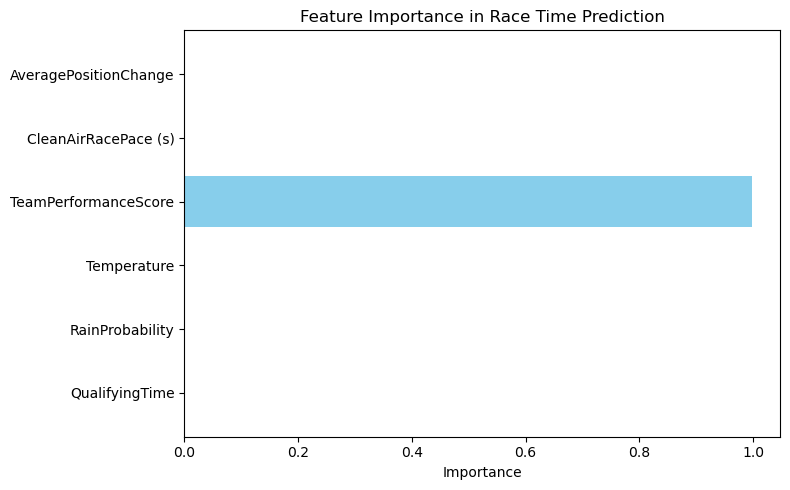

In [108]:
# plot: feature importance
feature_importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance in Race Time Prediction")
plt.tight_layout()
plt.show()